# Inspect ScaleVarianceTask on templates

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler, DatasetRef
from lsst.ip.diffim.getTemplate import GetCoaddAsTemplateConfig, GetCoaddAsTemplateTask
from astropy.visualization import ZScaleInterval
plt.rcParams['figure.figsize'] = (8.5, 5)
from lsst.pipe.tasks.scaleVariance import ScaleVarianceTask, ScaleVarianceConfig
import lsst.geom as lsstGeom
import numpy as np

In [4]:
butler = Butler("/project/gkovacs/run_sessions/repo_DM-22396/repo", collections='DM-22396_pccd', writeable=False)
skyMapRef = butler.registry.findDataset("skyMap", dataId={'skymap': "deepCoadd_skyMap"})
skyMap = butler.get(skyMapRef)
coaddRefs = butler.registry.queryDatasets("deepCoadd", dataId = {'band': 'g' })
exposure = butler.get("calexp", visit=412060, detector=25)

In [5]:
# get deferred dataset handles - otherwise .get() would load the whole coadd
availableCoaddRefs = {}
for cRef in coaddRefs:
    dataId = cRef.dataId
    availableCoaddRefs[dataId['patch']] = butler.getDeferred(cRef)

In [18]:
task = GetCoaddAsTemplateTask(config= GetCoaddAsTemplateConfig())
tractInfo, patchList, skyCorners = task.getOverlapPatchList(exposure, skyMap)

templateExp = task.run(tractInfo, patchList, skyCorners, availableCoaddRefs)
templateExp_orig = templateExp.clone()

In [9]:
# Show the image with the centroids of the selected sources
zScaler = ZScaleInterval()
vmin, vmax = zScaler.get_limits(templateExp.image.array)
bbox = templateExp.getBBox()

<IPython.core.display.Javascript object>


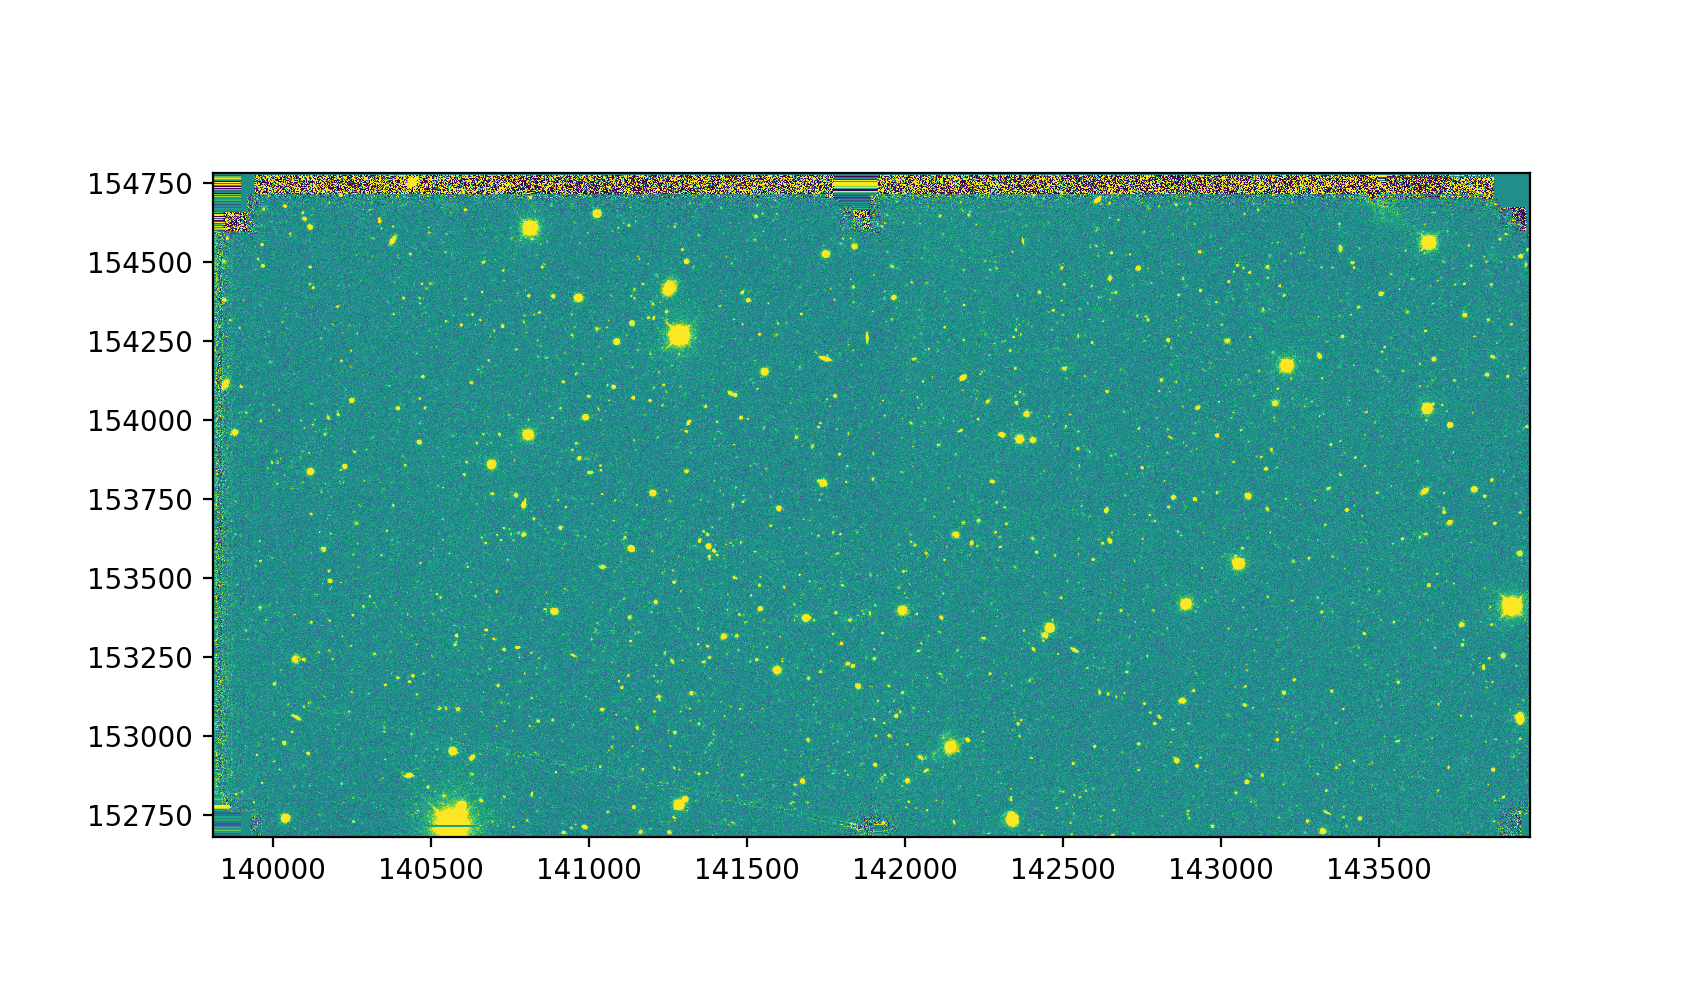

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.imshow(templateExp.image.array, origin='lower', interpolation='none', vmin=vmin, vmax=vmax, 
          extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])

In [11]:
#bmask = templateExp.mask.getPlaneBitMask(scaleConfig.maskPlanes)
bmask = templateExp.mask.getPlaneBitMask(['DETECTED', 'DETECTED_NEGATIVE', 'BAD', 'SAT', 'NO_DATA', 'INTRP' ])
A = np.asarray((templateExp.mask.array & bmask) != 0 , dtype = int)

<IPython.core.display.Javascript object>


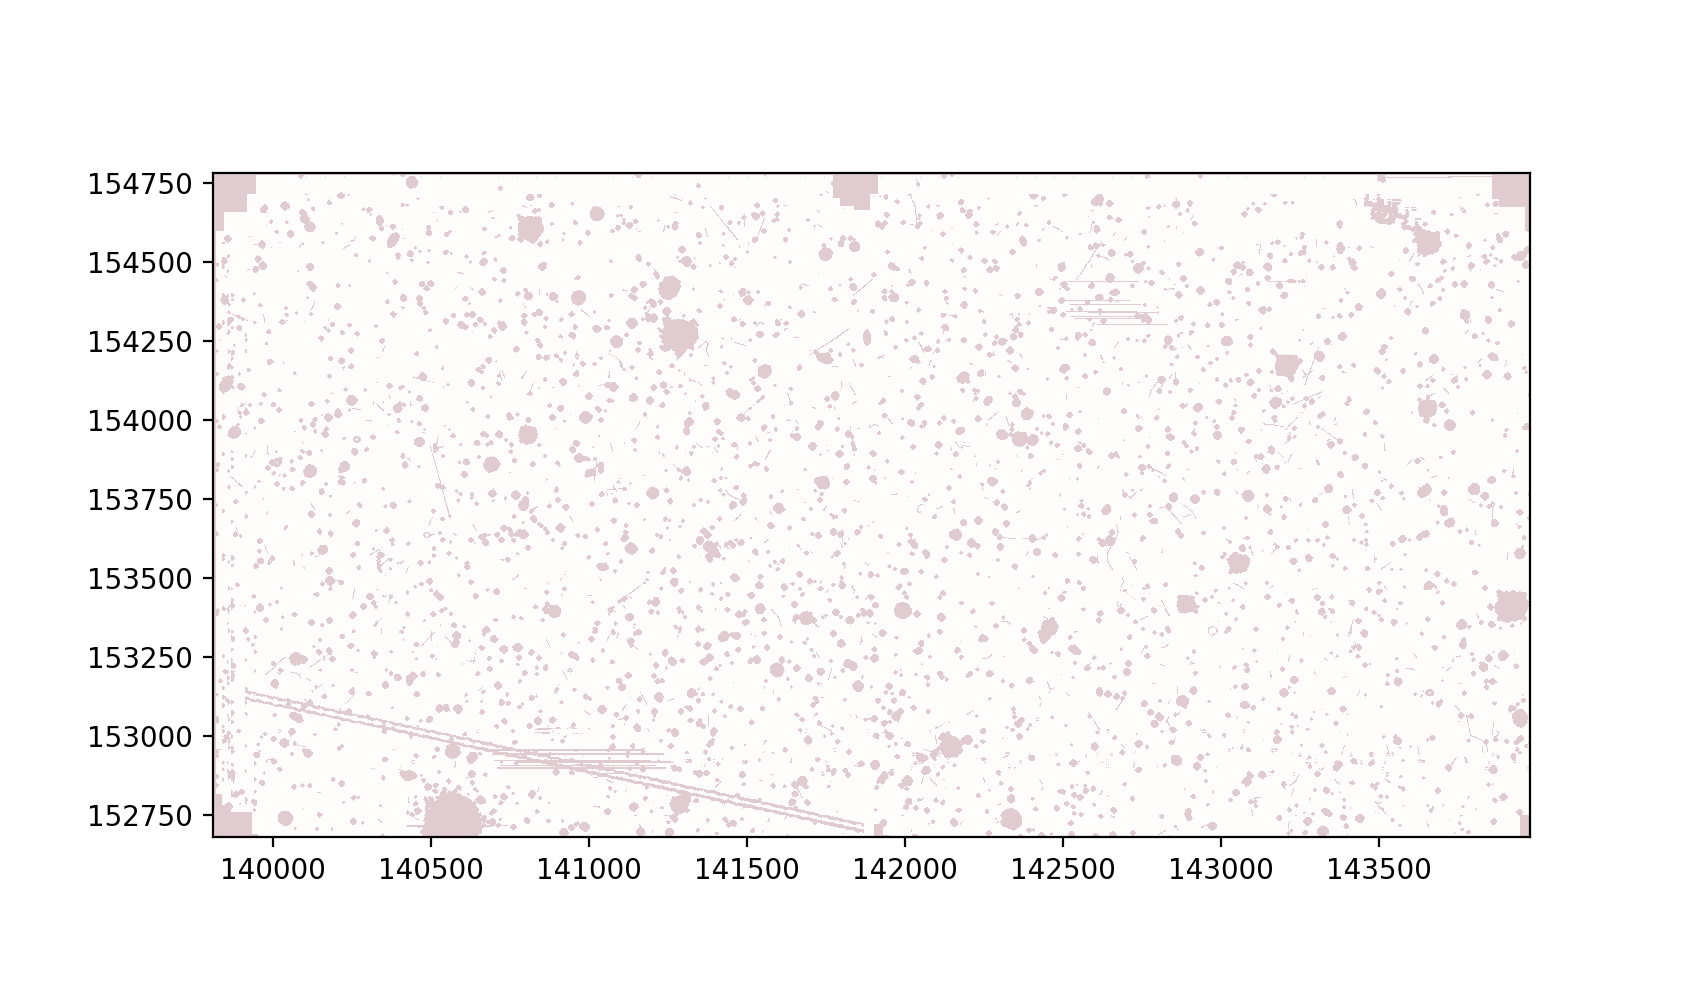

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(A, origin='lower', interpolation='none', alpha= 0.2, cmap='Reds',
          extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])

Check whether modifying the mask bits make any difference.

In [19]:
scaleConfig = ScaleVarianceConfig()

In [20]:
scaleTask = ScaleVarianceTask(config=scaleConfig)
scaleFactor = scaleTask.calculateBothFactors(templateExp.getMaskedImage())
print(scaleFactor)

Struct(pixFactor=0.6841604487304634; imageFactor=0.7509780302318932)


In [21]:
scaleConfig.maskPlanes.extend(['REJECTED', 'EDGE', 'SENSOR_EDGE'])

In [22]:
scaleTask = ScaleVarianceTask(config=scaleConfig)
scaleFactor = scaleTask.calculateBothFactors(templateExp.getMaskedImage())
print(scaleFactor)

Struct(pixFactor=0.6824856637955105; imageFactor=0.7169308992420176)


A: Not really.

-------

Check one patch

In [34]:
patchInfo = patchList[1]

In [35]:
patchNumber = tractInfo.getSequentialPatchIndex(patchInfo)

In [36]:
singleP = butler.get("deepCoadd", band='g', tract=tractInfo.getId(), patch=patchNumber)

In [37]:
# Show the image with the centroids of the selected sources
zScaler = ZScaleInterval()
vmin, vmax = zScaler.get_limits(singleP.image.array)
bbox = singleP.getBBox()

<IPython.core.display.Javascript object>


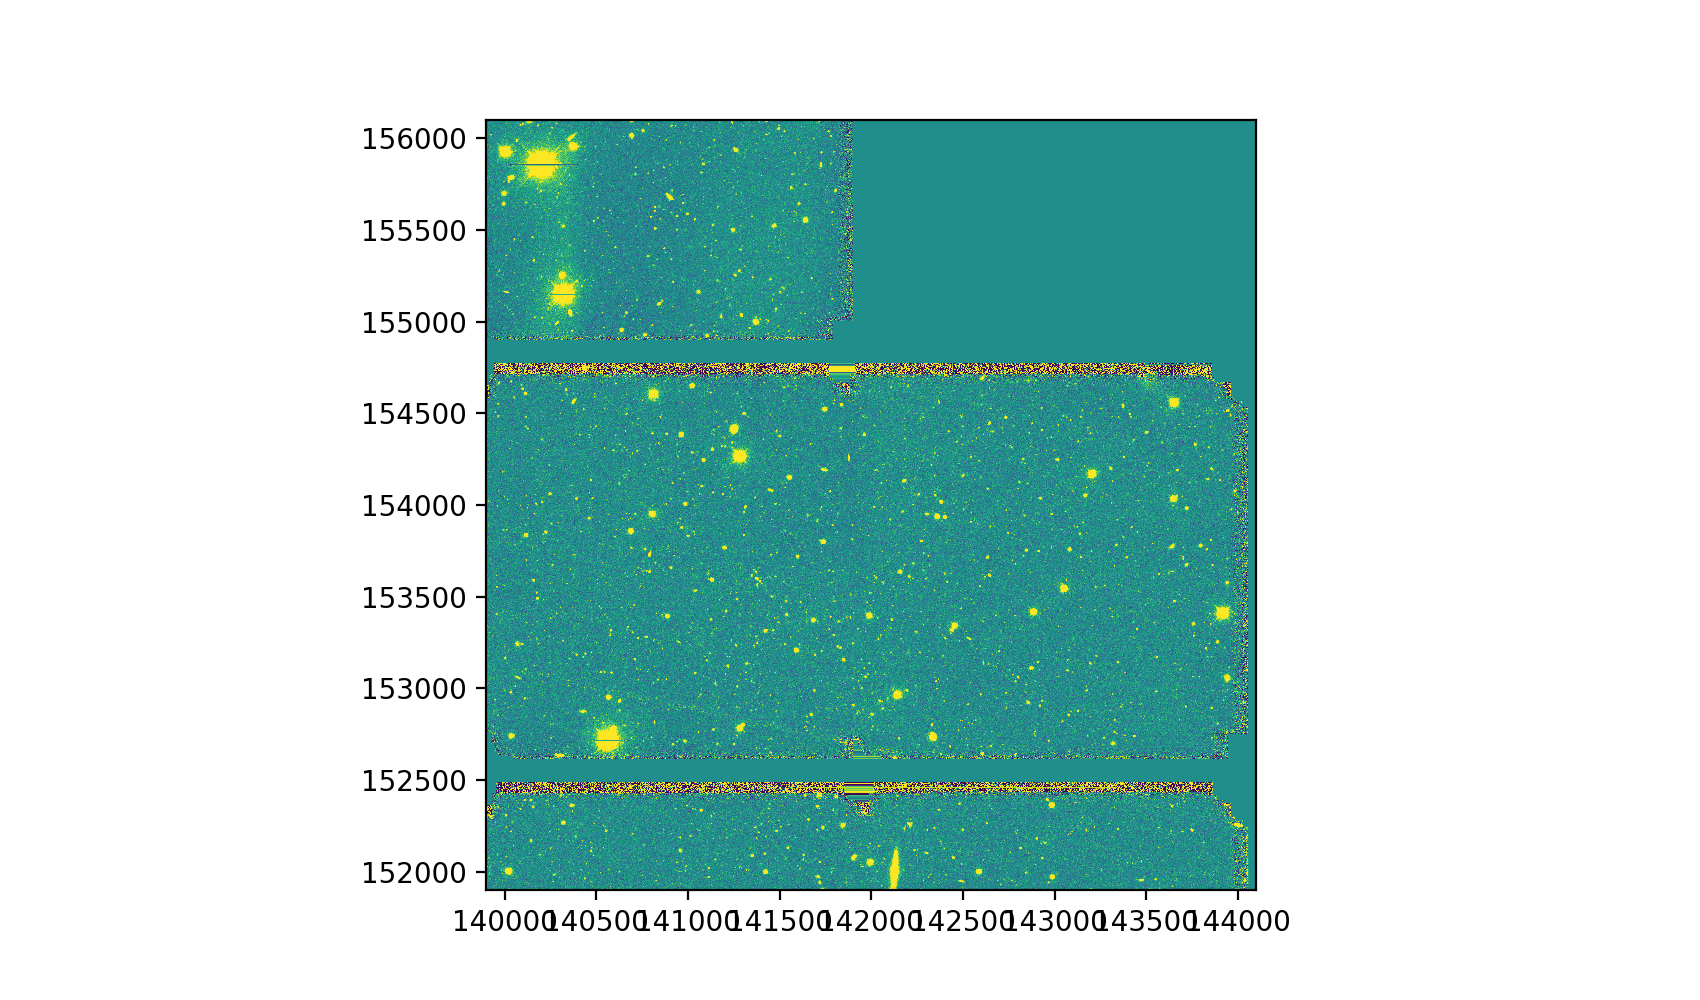

In [38]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

ax1.imshow(singleP.image.array, origin='lower', interpolation='none', vmin=vmin, vmax=vmax, 
          extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])

<IPython.core.display.Javascript object>


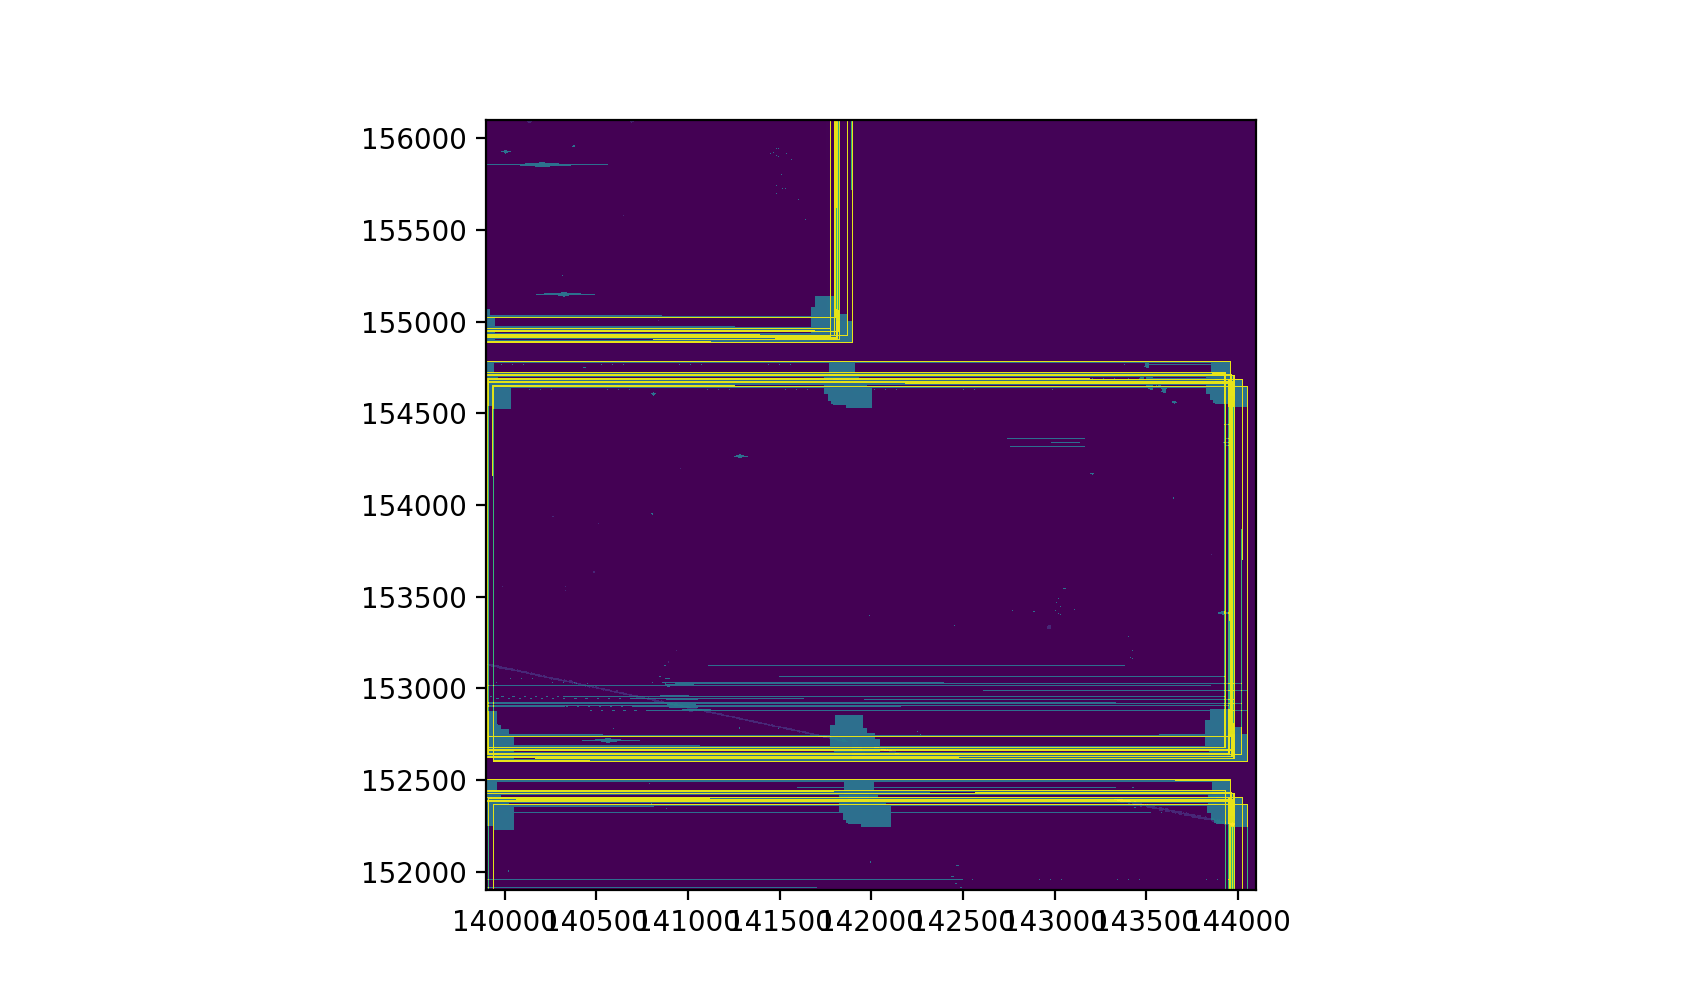

In [39]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

ax1.imshow(singleP.mask.array, origin='lower', interpolation='none',
          extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])

In [40]:
scaleTask = ScaleVarianceTask(config=scaleConfig)
scaleFactor = scaleTask.calculateBothFactors(singleP.getMaskedImage())
print(scaleFactor)

Struct(pixFactor=0.6997189377338453; imageFactor=0.7378736663058582)


---------

Check the template if the edges are cropped

In [41]:
templateExp = templateExp_orig.clone()

In [42]:
bbox = templateExp.getBBox()
bbox = bbox.erodedBy(500)
templateExp = templateExp[bbox]

In [43]:
# Show the image with the centroids of the selected sources
zScaler = ZScaleInterval()
vmin, vmax = zScaler.get_limits(templateExp.image.array)


<IPython.core.display.Javascript object>


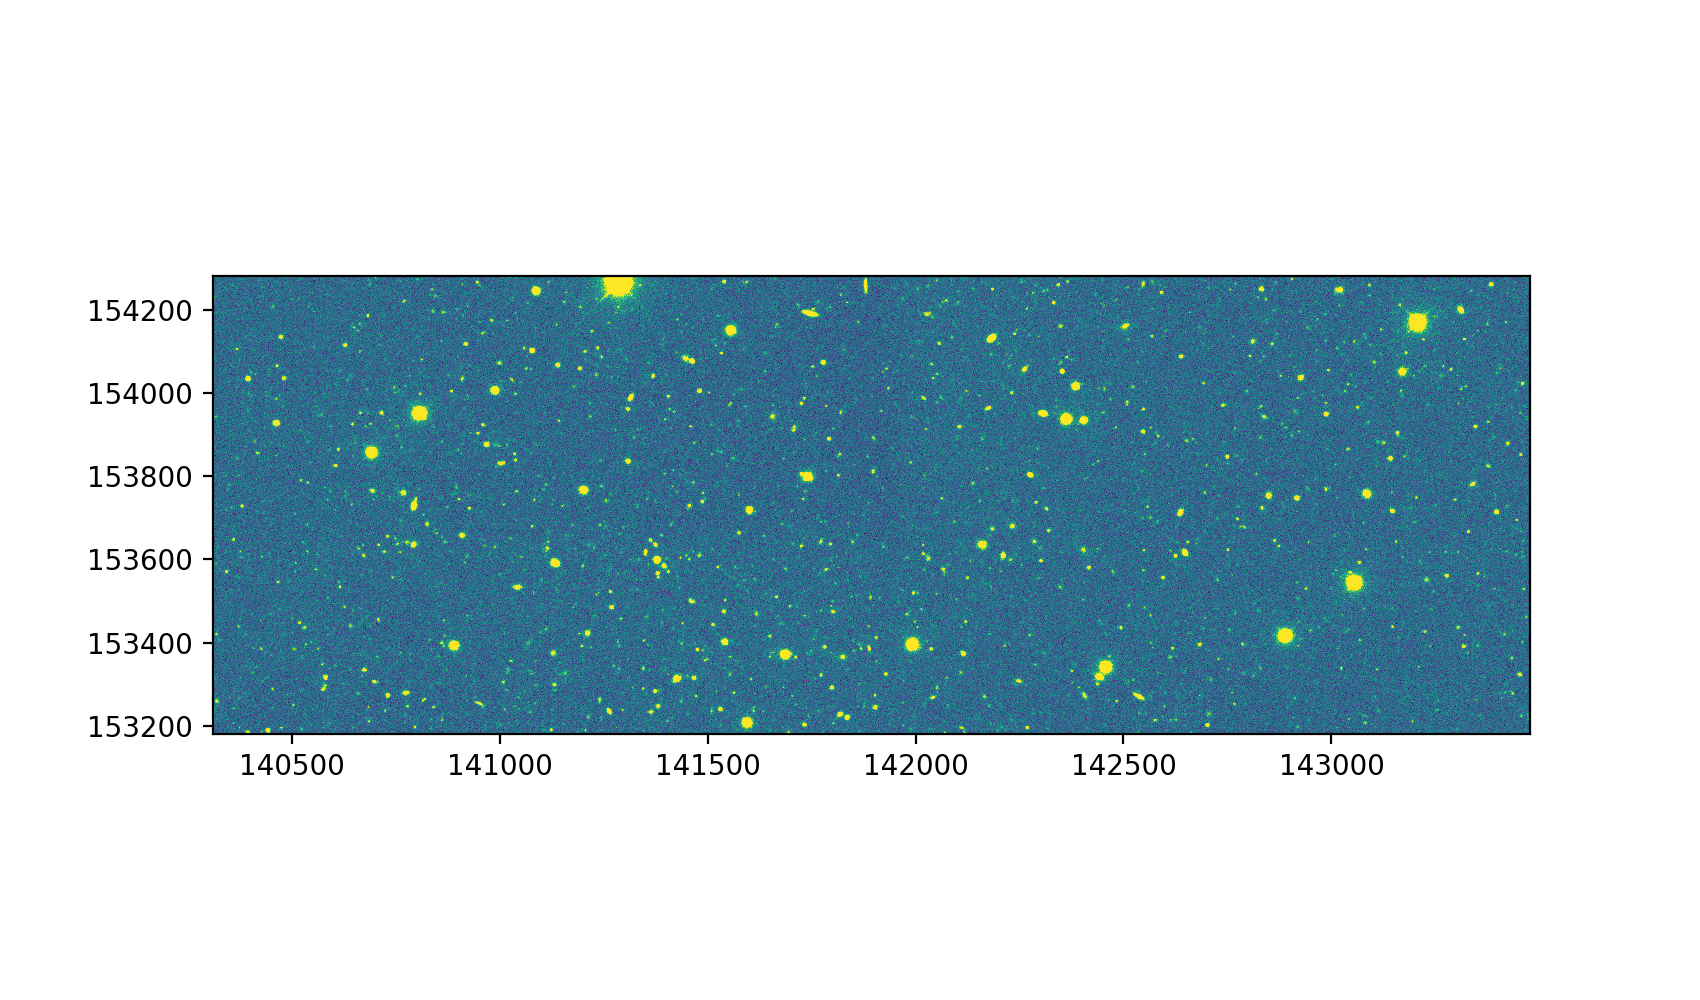

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.imshow(templateExp.image.array, origin='lower', interpolation='none', vmin=vmin, vmax=vmax, 
          extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])

In [45]:
#bmask = templateExp.mask.getPlaneBitMask(scaleConfig.maskPlanes)
bmask = templateExp.mask.getPlaneBitMask(['DETECTED', 'DETECTED_NEGATIVE', 'BAD', 'SAT', 'NO_DATA', 'INTRP' ])
A = np.asarray((templateExp.mask.array & bmask) != 0 , dtype = int)

<IPython.core.display.Javascript object>


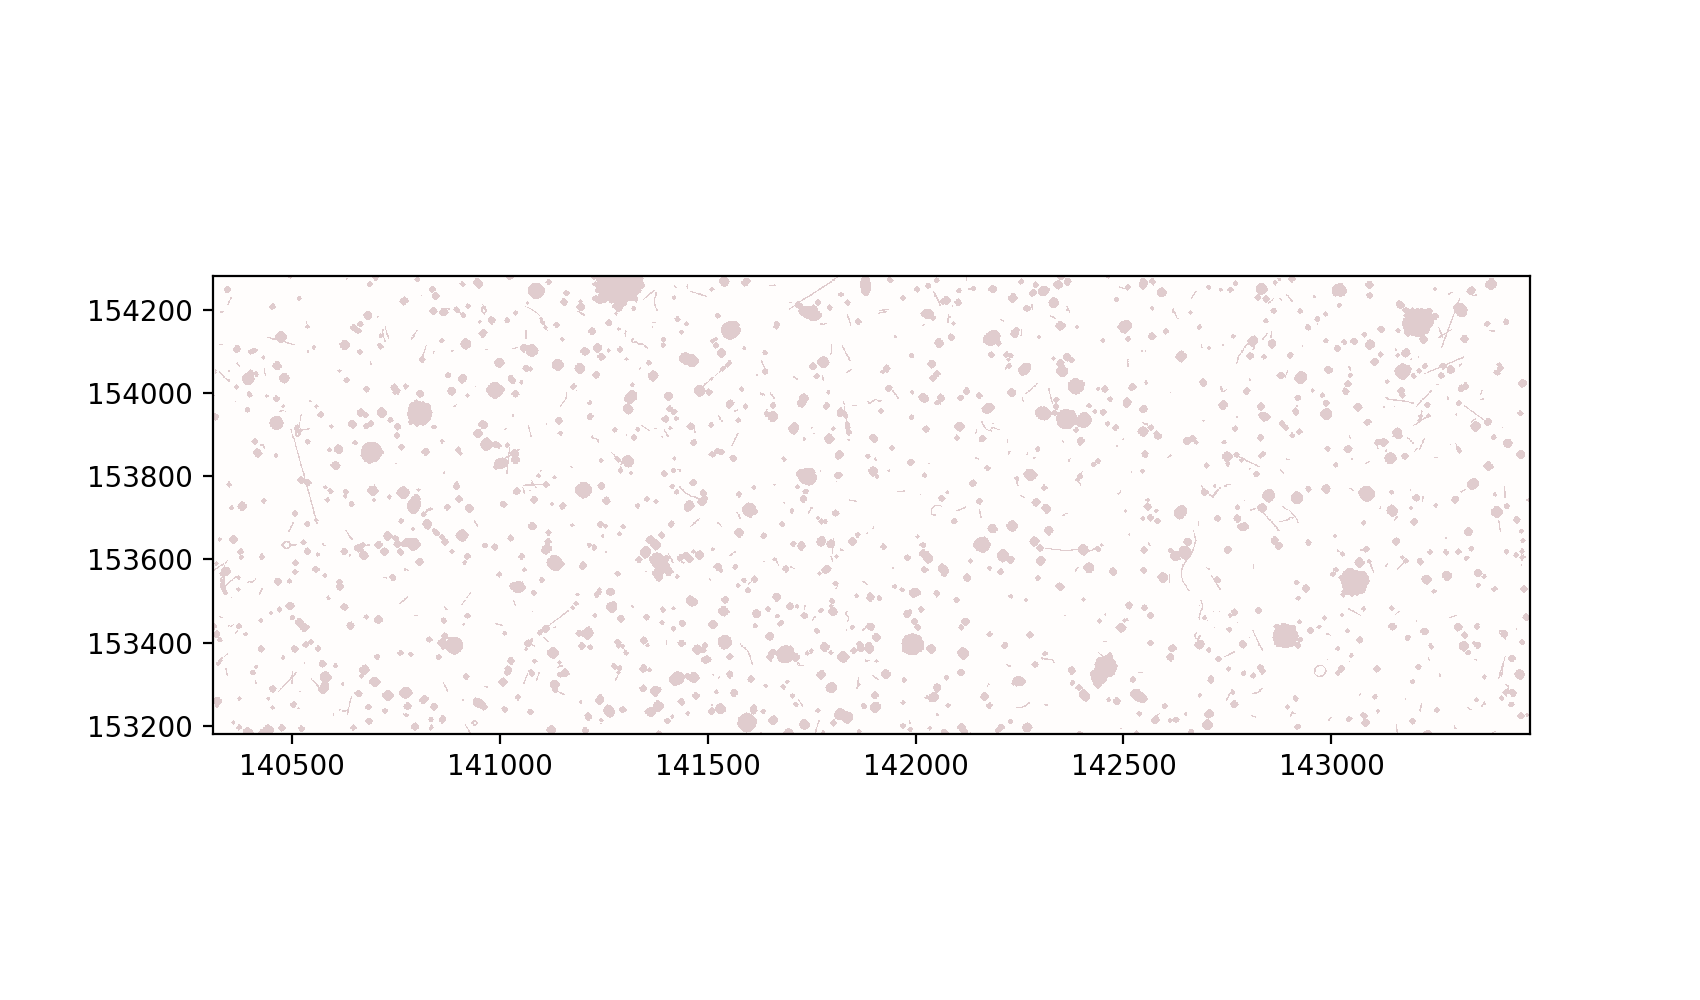

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(A, origin='lower', interpolation='none', alpha= 0.2, cmap='Reds',
          extent=[bbox.getMinX()-0.5, bbox.getMaxX()+0.5, bbox.getMinY()-0.5, bbox.getMaxY()+0.5])

In [47]:
scaleConfig = ScaleVarianceConfig()

scaleTask = ScaleVarianceTask(config=scaleConfig)
scaleFactor = scaleTask.calculateBothFactors(templateExp.getMaskedImage())
print(scaleFactor)

Struct(pixFactor=0.6771317708237221; imageFactor=0.6758303614511363)
